
### LIBRARIES 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pycce as pc
import scipy as sp
from scipy import stats
from __future__ import print_function
from scipy.optimize import curve_fit

from pycce.bath.array import common_concentrations

import ase
from ase.build import bulk

from mpl_toolkits import mplot3d



### .XYZ FILE 

In [2]:
seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)


filename="ti.xyz"
xyz=open(filename)
#print(xyz.read())
lines = []

xh=[]
yh=[]
zh=[]
sh=[]

xc=[]
yc=[]
zc=[]
sc=[]

xt=[]
yt=[]
zt=[]
st=[]

for line in xyz:
    lines.append(line)
    atom, x, y, z = line.split()
    if atom == 'H':
        xh.append(float(x))
        yh.append(float(y))
        zh.append(float(z))
        sh.append(str(atom))
    elif atom == 'C':
        xc.append(float(x))
        yc.append(float(y))
        zc.append(float(z))
        sc.append(str(atom))
    else:
        xt.append(float(x))
        yt.append(float(y))
        zt.append(float(z))
        st.append(str(atom)) 

n_atoms=len(lines)
print('The file has: ',n_atoms, 'atoms')

print(len(sh), ' hidrogen atoms')
print(len(sc), ' carbon atoms')
print(len(st), ' titanium atoms')
print(xt)
print(yt)
print(zt)


The file has:  108 atoms
52  hidrogen atoms
52  carbon atoms
4  titanium atoms
[3.87004716, 1.71895284, 7.30795284, 9.45904716]
[2.74825, 8.24475, 8.24475, 2.74825]
[4.58613288, 0.35163288, 3.88286712, 8.11736712]


### VISUALIZATION

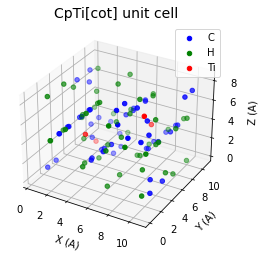


The presented arrangement of points on the 3D plot are the coordinates of each of the atoms in the .xyz file


In [3]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d') 

ax.scatter3D(xc,yc,zc, c='b', marker='o', label='C')
ax.scatter3D(xh, yh, zh, c='g', marker='o', label='H')
ax.scatter3D(xt, yt, zt, c='r', marker='o', label='Ti')


ax.legend()
ax.set_xlabel('X (A)')
ax.set_ylabel('Y (A)')
ax.set_zlabel('Z (A)')
plt.title("CpTi[cot] unit cell", fontsize = 14) 

plt.show()

print('\nThe presented arrangement of points on the 3D plot are the coordinates of each of the atoms in the .xyz file')


### BATH OF SPINS 

In [4]:
titanium=pc.BathCell(11.1780,10.9930,8.4690,90.0,90.0,90.0, angle='deg', cell=None)
titanium.zdir=([0,0,1])

for i in range(n_atoms):
    line=lines[i]
    atom,x,y,z = line.split()
    titanium.add_atoms((str(atom),[float(x),float(y),float(z)]), type='cell') #cell assumes crystallographic coordinates


remove_titanium=titanium.to_cell([xt[3], yt[3], zt[3]])
print('the central Ti to be removed is in the cell unit coordinates: \n',remove_titanium,'\n')

titanium.add_isotopes(('H','2H',1.0),('C', '1H',0.0),('Ti','47Ti',0.0))

cell = titanium.gen_supercell(100, add=None, remove=('Ti', remove_titanium), seed=seed, recenter=True)

print('the number of spins in this cell is: ',len(cell), '\n')
print('Unit cell properties: \n\n ',titanium)
print('the names of the isotopes inside the cell are: \n\n',cell[:].N)



the central Ti to be removed is in the cell unit coordinates: 
 [0.84622 0.25    0.95848] 

the number of spins in this cell is:  56160 

Unit cell properties: 

  BathCell containing:
52 positions for C with 1H: 0.0.
52 positions for H with 2H: 1.0.
4 positions for Ti with 47Ti: 0.0.

Cell:
[[11.178  0.     0.   ]
 [ 0.    10.993  0.   ]
 [ 0.     0.     8.469]]

z-direction: [0. 0. 1.]

the names of the isotopes inside the cell are: 

 ['2H' '2H' '2H' ... '2H' '2H' '2H']


### SIMULATOR

In [5]:
#parameters for the simulator


order=2  #maximum amount of spins the simulatior will use for the simulations
r_bath = 30 #max distance from the central spin to the bath spin to be considered as active bath spins 
r_dipole=6 #max distance from one spin to the other.

#the simulator only takes the position of the central spin in cartesian coordinates
position=titanium.to_cartesian([xt[3], yt[3], zt[3] ])
D = 2.88 * 1e6 # in kHz
print(position) #this is for me to know the cartesian coordinates
E = 0 # in kHz
b=25000  #strong external magnetic field

spin = pc.CenterArray(spin=0.5, position=position, alpha=1, beta=0)
calc = pc.Simulator(spin=spin, bath=cell, r_bath=r_bath, r_dipole=r_dipole, order=order, magnetic_field=b)
print(calc)

[105.73323  30.21151  68.74598]
Simulator for center array of size 1.
magnetic field:
array([    0.,     0., 25000.])

Parameters of cluster expansion:
r_bath: 30
r_dipole: 6
order: 2

Bath consists of 1657 spins.

Clusters include:
1657  clusters of order 1.
10814  clusters of order 2.



In [6]:
# Time points
time_space = np.linspace(0, 0.5, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b =25000  # in G

# Calculate coherence function with cCCE
l_cCCE = calc.compute(time_space, pulses=n, method='cce', quantity='coherence', as_delay=False, magnetic_field=b)



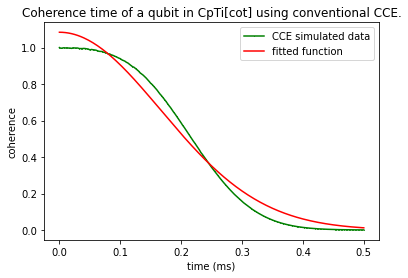

In [7]:
x_data = np.asarray(time_space)
y_data = np.asarray(l_cCCE.real)
#plt.plot(x_data, y_data, 'o')

#define the gaussian function
def Gauss(x,A,B):
    y=A*np.exp(-1*B*x
            **2)
    return y
parameters, covariance = curve_fit(Gauss,x_data,y_data)

fit_A=parameters[0]
fit_B=parameters[1]


fit_y=Gauss(x_data, fit_A, fit_B)
curve,=plt.plot(x_data, y_data, ms=0.2, c='g', marker='*', label='CCE simulated data')
plt.plot(x_data, fit_y, '-', c='r', label='fitted function')
#plt.ylim(0.98, 1.0)
plt.legend(bbox_to_anchor=(0.8,1.11), ncol=3)
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('coherence')
plt.title('Coherence time of a qubit in CpTi[cot] using conventional CCE.')
plt.show()

In [8]:
spin = pc.CenterArray(spin=0.5, position=position, D=D, E=E, alpha=0,beta=1)
calc = pc.Simulator(spin=spin, bath=cell, r_bath=r_bath, r_dipole=r_dipole, order=order)

#Hanh-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function with gCCE
l_gCCE = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

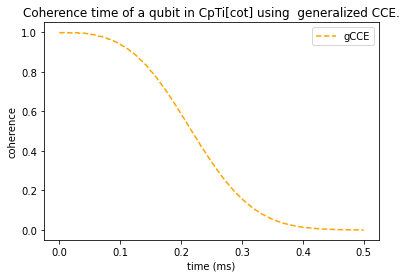

In [9]:

plt.plot(time_space, l_gCCE.real, color='orange', ls='--', label='gCCE')

plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('coherence')
plt.title('Coherence time of a qubit in CpTi[cot] using  generalized CCE.');

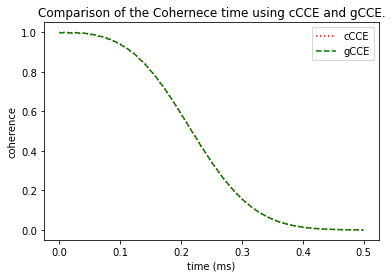

In [10]:
plt.plot(time_space, l_cCCE.real, color='red', ls='dotted', label='cCCE')
plt.plot(time_space, l_gCCE.real, color='green', ls='dashed', label='gCCE')

plt.legend(loc='best')
plt.xlabel('time (ms)')
plt.ylabel('coherence')
plt.title('Comparison of the Cohernece time using cCCE and gCCE.')
plt.legend()


### CONVERGENCE GRAPHS

In [11]:
spin = pc.CenterArray(spin=0.5, position=position, D=D, E=E, alpha=0,beta=1)
position = titanium.to_cartesian([xt[3], yt[3], zt[3]])
parameters = dict(
    order=2, # CCE order
    r_bath=30,  # Size of the bath in A
    r_dipole=6,  # Cutoff of pairwise clusters in A
    position=position, # Position of central Spin
    pulses = 1, # N pulses in CPMG sequence
    magnetic_field=25000 
) # Qubit levels

time_space = np.linspace(0, 0.10, 201)  # Time points in ms

def runner(variable, values):
    invalue = parameters[variable]
    calc = pc.Simulator(spin=spin, bath=cell, **parameters)
    ls = []

    for v in values:
        setattr(calc, variable, v)
        l = calc.compute(time_space, method='cce',
                         quantity='coherence')

        ls.append(l.real)

    parameters[variable] = invalue
    ls = pd.DataFrame(ls, columns=time_space, index=values).T
    return ls

In [12]:
orders = runner('order', [1, 2])
rbs = runner('r_bath', [20, 30, 40,50,60])
rds = runner('r_dipole', [2,4,6,8])


Text(0, 0.5, 'coherence')

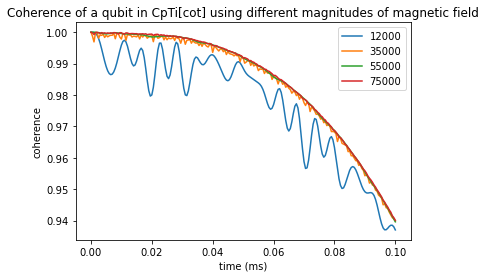

In [13]:
mg = runner('magnetic_field', [12000, 35000, 55000, 75000]) 
mg.plot(title='Coherence of a qubit in CpTi[cot] using different magnitudes of magnetic field')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('coherence')

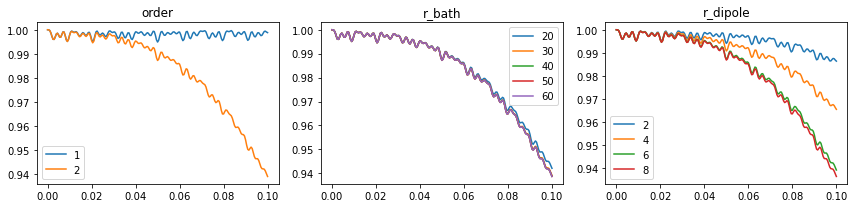

In [17]:
fig, axes = plt.subplots(1,3,figsize=(12,3))

orders.plot(ax=axes[0], title = 'order')
rbs.plot(ax=axes[1], title='r_bath')
rds.plot(ax=axes[2], title='r_dipole')

fig.tight_layout()

for x in axes:
    ax.set(xlabel='time(ms)', ylabel='coherence')
    plt.legend()



### T2 

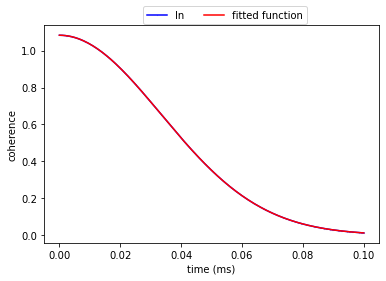

average of time 0.05
average of coherence 0.4395618207580314
0.003144823260742482


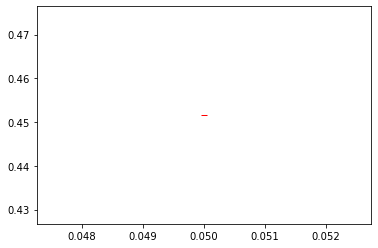

In [18]:
x_data = np.asarray(time_space)
y_data = np.asarray(l_cCCE.real)
#plt.plot(x_data, y_data, 'o')

#define the gaussian function
def Gauss(x,A,B):
    y=A*np.exp(-1*B*x**2)
    return y
parameters, covariance = curve_fit(Gauss,x_data,y_data)

fit_A=parameters[0]
fit_B=parameters[1]


fit_y=Gauss(x_data, fit_A, fit_B)

#ln_y = (x_data * x_data) / (np.log(fit_y)-0.085)
#ln_y = (-((x_data * x_data) / (np.log(fit_y))))
#ln_y = (-((x_data * x_data) / (np.log(y_data))))

#curve,=plt.plot(x_data, ln_y, ms=0.2, c='b', marker='.', label='ln')

curve,=plt.plot(x_data, fit_y, ms=0.2, c='b', marker='.', label='ln')

#curve,=plt.plot(x_data, y_data, ms=0.2, c='g', marker='.', label='CCE simulated data')
plt.plot(x_data, fit_y, '-', c='r', label='fitted function')
#plt.ylim(0.98, 1.0)
plt.legend(bbox_to_anchor=(0.8,1.11), ncol=3)

plt.xlabel('time (ms)')
plt.ylabel('coherence')

plt.show()
#print(fit_y,'\n')
#print('time(ms)',x_data)
#print( 'ln', ln_y)
average_time = np.average(x_data)
average_lc = np.average(y_data)
print('average of time', average_time)
print('average of coherence', average_lc)

average_fit = np.average(fit_y)

T = (-(average_time*average_time) / np.log (average_fit))
print(T)
#print(ln_y)
plt.plot(average_time, average_fit, '_', c='r', label='ln')
plt.show()
#0.010534225482759684

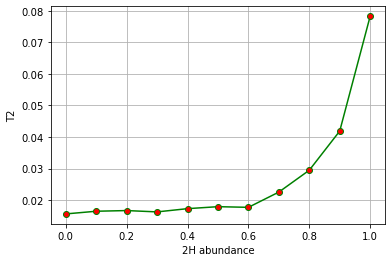

In [19]:
deut_abundance=(1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.0)
decoh = (
0.078246835,
0.041864554,
0.029467464,
0.022541004,
0.017709072,
0.017918429,
0.017290949,
0.016264418,
0.0166848,
0.016472925,
0.015624211,
)
x = deut_abundance
y= decoh


plt.xlabel('2H abundance')
plt.ylabel('T2')


plt.plot(x,y,  c='green', mfc='red', marker='o')
plt.grid()

plt.show()

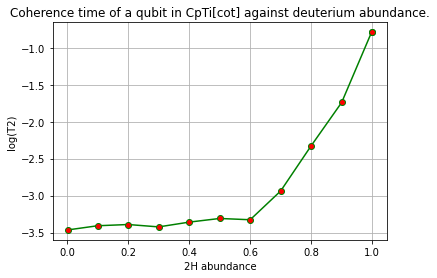

In [20]:
deut_abundance=(0.002,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.998,1)
#log_decoh = (-3.464126363,-3.407723208, -3.391123688, -3.42329143, -3.358759045, -3.309326917, -3.326613636, -2.937553154, -2.326143654, -1.740654285, -0.790616445,-0.790617331)
log_decoh = (-3.464126363,-3.407723208, -3.391123688, -3.42329143, -3.358759045, -3.309326917, -3.326613636, -2.937553154, -2.326143654, -1.740654285, -0.790616445,-0.790617331)

x = deut_abundance
y= log_decoh
plt.xlabel('2H abundance')
plt.ylabel('log(T2)')
plt.title('Coherence time of a qubit in CpTi[cot] against deuterium abundance.')
plt.plot(x,y,  c='green', mfc='red', marker='o')
plt.grid()

plt.show()